# huggingface + WRIMEデータセット で感情推定

## 環境構築

In [2]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 31.7 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=739cc1b524602f9ff08cc0405c40e0342b00d7c9f915395bfabbbb8d675e9bd3
  Stored in directory: /root/.cache/pip/wheels/44/56/37/f543963822b85260c9f948df8fac8c20169c80dc71b24dc407
Successfully built ipadic


In [3]:
import numpy as np
import pandas as pd

In [4]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

### Matplotlibで日本語を使用できるようにする

In [5]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 2s (4,562 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

Text(0.5, 1.0, '日本語を表示できるかテスト')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31034 (

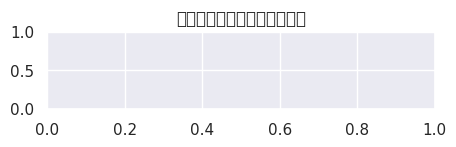

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

## データセットの準備

### WRIMEデータセットのダウンロード

In [12]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2025-06-19 01:55:47--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2025-06-19 01:55:47--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487235 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv.1’

wrime-ver1.tsv.1    100%[===================>]   9.05M  --.-KB/s    in 0.07s   

2025-06-19 01:55:47 (139 MB/s) - ‘wrime-ver1.tsv.1’ saved [9487235/9487235]



In [13]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


### 前処理

__前提①：WRIMEデータセットのラベルは、各感情の強度__
- 各感情（例えば、Joy=喜）の強度を、0〜3の４段階でラベル付けしている
- ８つの感情全てにおいて、最頻ラベルは「0」


__前提②：WRIMEデータセットには、複数種類のラベルが付与されている__
1. Writer_*
    - 文章の __書き手__ が自身で付与したラベル。「主観感情」。
2. Reader{1,2,3}_* :
    - 文章の __読み手__ が付与したラベル。「客観感情」。３名分。
3. Avg.Readers_*
    - ３名分の客観感情の平均値。

問題設定
1. ８つの感情の、分類タスクとして扱う
    - 相対的にどの感情が強いかを推定する
    - データセットの本来の用途としては感情強度を推定するタスク。しかしながら、感情強度=0のサンプルが多く、やや扱いが難しいため、今回は簡素化して扱う。
2. 客観感情の平均値を使用する
    - 論文において、主観感情と客観感情は異なることが指摘されている
    - 主観感情は、書き手の性格や表現方法に依存する部分がある。そのため、客観感情、かつ、その平均値を用いることで、推定結果の納得感が高くなることが期待される

In [14]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [15]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


## モデル(BERT)を訓練する

### Tokenizerで入力データに変換

In [18]:
!pip install "fugashi[unidic-lite]"  # Colab なら行頭に ! を付ける
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=b2cfd8058e738628d9f35dc29e5e5ddbfaf3fd57497a7ff2b176e5f64405ed20
  Stored in directory: /root/.cache/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic-lite


In [19]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

### 訓練済みモデルの読み込み

In [20]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 訓練を実行

In [21]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

/tmp/ipython-input-21-3063707975.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# Transformers の Trainer を用いる
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments

!pip install --upgrade transformers

# 訓練時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    eval_strategy="steps", # evaluation_strategy を eval_strategy に変更
    eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nitichidasho (nitichidasho-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
200,No log,0.266780,0.603707
400,No log,0.246610,0.639894


## 訓練したモデルで推論する

In [ ]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [ ]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)

In [ ]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

In [ ]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

In [ ]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)

In [ ]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

In [ ]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)

In [ ]:
analyze_emotion('まじでごめん' show_fig=True)

In [ ]:
analyze_emotion('へ～、これこういう仕組みなんだ～' show_fig=True)